In [22]:
import sys
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import entr, logsumexp
import matplotlib.cm as cm

In [11]:
file_path_07 = "/home/gridsan/mshi/gpt2/llama2_-1_999_2_0.7/output_2025-02-23_20-04-54.pkl"
file_path_03 = "/home/gridsan/mshi/gpt2/llama2_-1_999_2_0.3/output_2025-02-23_21-36-33.pkl"
file_path_18 = "/home/gridsan/mshi/gpt2/llama2_-1_999_2_1.8/output_2025-02-23_23-04-50.pkl"
file_path_12 = "/home/gridsan/mshi/gpt2/llama2_-1_999_2_1.2/output_2025-02-23_23-19-12.pkl"

files_dict = {
    0.3: file_path_03,
    0.7: file_path_07,
    1.2: file_path_12,
    1.8: file_path_18,
}


In [45]:
EPSILON = 1e-30  # Small value to prevent log(0)

def stable_softmax(log_probs):
    """Compute softmax in a numerically stable way using logsumexp."""
    log_probs_max = np.max(log_probs, axis=1, keepdims=True)  # Stabilize by subtracting max
    log_probs_stable = log_probs - log_probs_max
    probs = np.exp(log_probs_stable)
    probs /= np.exp(logsumexp(log_probs_stable, axis=1, keepdims=True))
    return probs

def compute_entropy(log_probs):
    """Compute entropy with numerically stable softmax and clipping."""
    probs = stable_softmax(log_probs)
    probs = np.clip(probs, EPSILON, 1.0)  # Ensure no exact zeros
    entropy = np.sum(entr(probs), axis=1)  # SciPy's `entr(p)` computes `-p log p`
    print(len(np.sum(probs, axis=1)))
    return entropy

In [41]:
def moving_average(data, window_size=100):
    """Compute a simple moving average for smoothing."""
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

def plot_entropy(sequence):
    entropy_values = compute_entropy(sequence)
#     print(len(entropy_values))

#     # Plot entropy over token positions
#     plt.figure(figsize=(10, 5))
#     plt.scatter(range(1, len(entropy_values) + 1), entropy_values, label="Entropy", color="blue")
#     plt.xlabel("Token Position")
#     plt.ylabel("Entropy")
#     plt.title("Temperature")
#     plt.legend()
#     plt.show()
    
    
    # Compute moving average
    smooth_entropy = moving_average(entropy_values, window_size=50)
    smooth_x = np.arange(1, len(smooth_entropy) + 1)  # Adjusted x-axis

    # Plot scatterplot and moving average
    plt.figure(figsize=(10, 5))
    plt.scatter(range(1, len(entropy_values) + 1), entropy_values, label="Entropy", color="blue", alpha=0.3, s=10)
    plt.plot(smooth_x, smooth_entropy, color="red", label="Moving Average (window=20)", linewidth=2)

    plt.xlabel("Token Position")
    plt.ylabel("Entropy (nats)")
    plt.title("Entropy over Generated Token Sequence with Moving Average")
    plt.legend()
    plt.show()



In [42]:
# with open(file_path, "rb") as file:
#     data = pickle.load(file)
# for sequence in data['output_log_probs']:
#     plot_entropy(sequence)

In [43]:
def plot_all_data(files):
    """
    Plot entropy of all temperatures in one plot with different scatter colors
    """
    plt.figure(figsize=(10, 5))

    num_temps = len(files)
    colors = cm.viridis(np.linspace(0, 1, num_temps))
    
    window = 50

    for i, (temp, fn) in enumerate(files.items()):
        with open(fn, "rb") as file:
            data = pickle.load(file)
            tokens = data['output_log_probs'][0]
            entropy_values = compute_entropy(tokens)

            smooth_entropy = moving_average(entropy_values, window_size=window)
            smooth_x = np.arange(1, len(smooth_entropy) + 1)

            plt.scatter(range(1, len(entropy_values) + 1), entropy_values, 
                        label=f"Entropy (T={temp})", color=colors[i], alpha=0.3, s=10)
            plt.plot(smooth_x, smooth_entropy, color=colors[i], label=f"Moving Avg (Window size={window})", linewidth=2)

    plt.xlabel("Token Position")
    plt.ylabel("Entropy (nats)")
    plt.title("Entropy over Generated Token Sequence with Moving Average")
    plt.legend()
    plt.show()


994
994
994
994


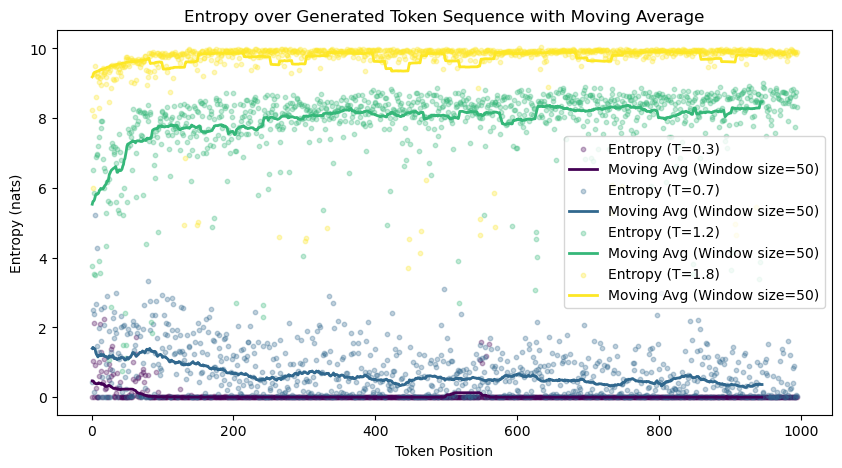

In [46]:
plot_all_data(files_dict)